## Comparing PHNNs with random or BLA initialisation
The notebook is structured according to these steps:

__Import data and BLA estimation from MATLAB__
- Import and visualise a dataset
- Separate the data into train, validation and test sets
- Import and check the JRGQ matrices from MATLAB

__Verify data with true model__
- Load the cheat_PHNN with the correct matrices and show that the simulated data can be perfectly matched

__Define and train several model classes__
- Train the default PHNN implementation from deepSI_lite
- Train the custom_PHNN
- Train the linear_PHNN
- Train the combined_PHNN

__Compare model class performances__
- Plot the training and validation losses over <font color='red'>_(1000)_</font> epochs
- Plot the qualitative simulation performance <font color='red'>_(all models in 1 plot will probably not be very informative, so instead plot $y_{1}$ simulation and combined n-step error)_</font>
- Summarize findings

In [1]:
import os
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt

from  deepSI_lite import Input_output_data
from utils import DK_matrix_form, RK4_multistep_integrator, simulate_model, simulate_model_withP, plot_simulation
from MSD_model import custom_PHNN, linear_PHNN, cheat_PHNN, combined_PHNN, fit_model

# Indicate filepath locations for the dataset, JRGQ matrices and the models to be saved:
PATH_DATA = "datasets/TEST_DATASET_GENERATED.pt"
PATH_MATRICES = "matlabIO/W17_BLA_matrices.mat"
PATH_MODEL_lin = "models/W13_linear_fit.pt"
PATH_MODEL_comb = "models/W16_combined_fit.pt"
PATH_MODEL_nonlin = "models/W13_nonlinear_fit.pt"

# Set figure parameters in advance
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['figure.facecolor'] = "eee8e8"
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.25

c:\Users\20174290\AppData\Local\miniconda3\envs\portHamiltonian\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import data and BLA estimation from MATLAB
- Import and visualise a dataset
- Separate the data into train, validation and test sets
- Import and check the JRGQ matrices from MATLAB

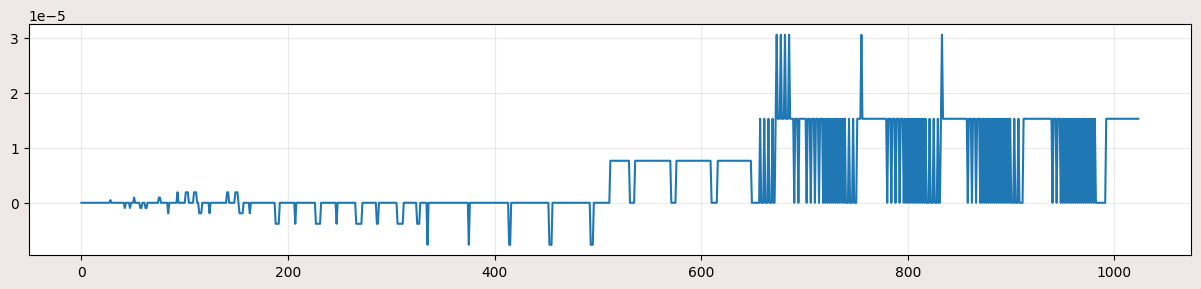

In [2]:
# TODO: Recreate the sim_time vector from data stored in the datasets.pt file
# Current best approximation is 
sim_time = torch.linspace(0, 200, 1024)
dt = sim_time[1]     # To be saved with the file
recreated_time = torch.arange(0, 200+dt, dt)
plt.plot(recreated_time-sim_time)


Number of datasets available: 8


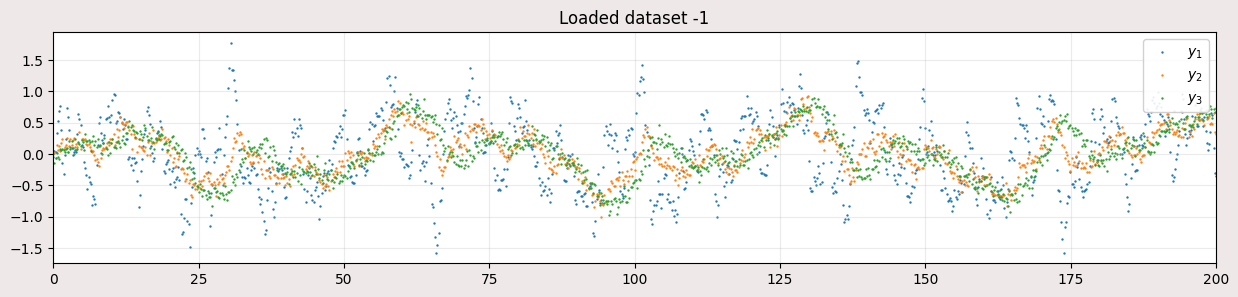

In [3]:
# Import the dataset and visualise the measurements
datasets = torch.load(PATH_DATA, weights_only=False)
print(f"Number of datasets available: {len(datasets)}")

z = -1
plt.scatter(sim_time, datasets[z]["noisy_output"][:, 0], s=0.5)
plt.scatter(sim_time, datasets[z]["noisy_output"][:, 1], s=0.5)
plt.scatter(sim_time, datasets[z]["noisy_output"][:, 2], s=0.5)
plt.legend(["$y_{1}$", "$y_{2}$", "$y_{3}$"], loc=1)
plt.title(f"Loaded dataset {z}")
plt.xlim([0, sim_time[-1]])
plt.show()

In [4]:
# Divide the datasets across training, validation and testing datasets
# The resulting objects are lists of deepSI_lite.Input_output_data objects
n_train = 5
n_val = 2
n_test = 1

dsi_train = []
dsi_val = []
dsi_test = []

for i, set in enumerate(datasets):
    if i < n_train:
        dsi_train.append(set["dsi_IO"])
    elif i < n_train+n_val:
        dsi_val.append(set["dsi_IO"])
    else:
        dsi_test.append(set["dsi_IO"])

In [5]:
# Import the Best Linear Approximation (BLA) of the dataset and check the results:
# NB: this approximation is done through the MATLAB ssest function
matrix_dict = scipy.io.loadmat(PATH_MATRICES)
J = torch.FloatTensor(matrix_dict["J"])
R = torch.FloatTensor(matrix_dict["R"])
G = torch.FloatTensor(matrix_dict["G"])
Q = torch.FloatTensor(matrix_dict["Q"])
P = torch.FloatTensor(matrix_dict["P"])
#print(J, R, G, Q, P)

### Verify data with true model
- Load the cheat_PHNN with the correct matrices and show that the simulated data can be perfectly matched

In [6]:
# Define the true system
x_test = torch.rand(1, 6)
system_dim = torch.IntTensor([[6, 3]])
na = nb = 10

M_vals = torch.FloatTensor([2, 2, 2])
D_vals = torch.FloatTensor([1, 1, 1])
K_vals = torch.FloatTensor([0.5, 0.5, 0.5])
M = torch.diag(M_vals)
D = DK_matrix_form(D_vals)
K = DK_matrix_form(K_vals)

# Initialise the model
cheat_model = cheat_PHNN(system_dim, na, nb, dt=sim_time[1], M=M, D=D, K=K, cubic=False)
#cheat_model.get_matrices(x_test)

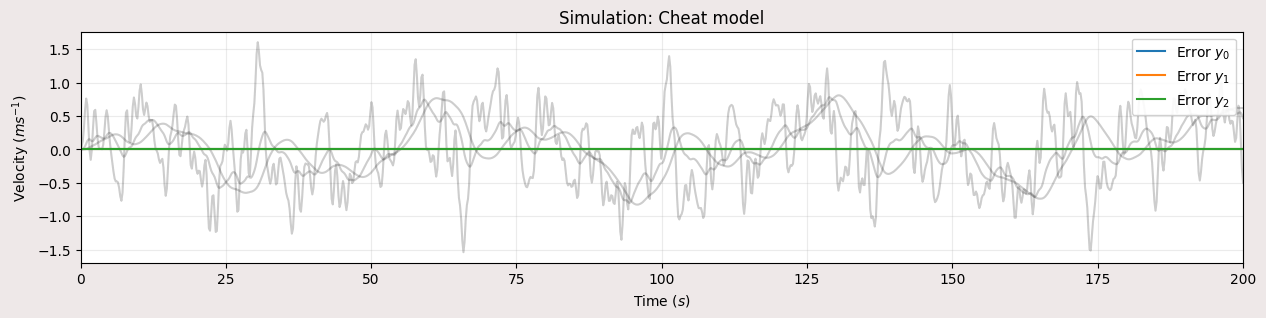

In [7]:
# Simulate the model to check if it fits the data
z = -1
x0 = torch.FloatTensor(datasets[z]["states"][0, :])
u = torch.FloatTensor(datasets[z]["inputs"])
cheat_states, cheat_outputs = simulate_model(sim_time=sim_time, model=cheat_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], cheat_outputs, plot_mode="error", title="Simulation: Cheat model")

### Define and train several model classes
- <font color='red'>_TODO: Train the default PHNN implementation from deepSI_lite_ </font>
- Train the custom_PHNN
- Train the linear_PHNN
- Train the combined_PHNN

In [8]:
# TODO: Train deepSI_lite model

In [9]:
# TODO: Implement lists of datasets as input to the training function

linear_model = linear_PHNN(system_dim, na, nb, dt=sim_time[1])
# If we have a saved model --> no need to train --> instead load the saved model statedict and training info
if os.path.isfile(PATH_MODEL_lin):
    lf_saved = torch.load(PATH_MODEL_lin, weights_only=False)
    linear_model.load_state_dict(lf_saved["state_dict"])
    lf_loss = lf_saved["train_loss"]
    lf_val_loss = lf_saved["val_loss"]
# Otherwise, we have to train the model and save it afterwards
else: 
    lf_loss, lf_val_loss, lf_best_sd = fit_model(linear_model, datasets[0]["dsi_IO"], datasets[0]["dsi_IO"], n_its=1001, T=200, stride=1)
    lf_train = {
        "train_loss":lf_loss,
        "val_loss":lf_val_loss,
        "state_dict":lf_best_sd
    }
    torch.save(lf_train, PATH_MODEL_lin)

In [10]:
nonlinear_model = custom_PHNN(system_dim, na, nb, dt=sim_time[1])

# If we have a saved model --> no need to train --> instead load the saved model statedict and training info
if os.path.isfile(PATH_MODEL_nonlin):
    nlf_saved = torch.load(PATH_MODEL_nonlin, weights_only=False)
    nonlinear_model.load_state_dict(nlf_saved["state_dict"])
    nlf_loss = nlf_saved["train_loss"]
    nlf_val_loss = nlf_saved["val_loss"]
# Otherwise, we have to train the model and save it afterwards
else: 
    nlf_loss, nlf_val_loss, nlf_best_sd = fit_model(nonlinear_model, datasets[0]["dsi_IO"], datasets[0]["dsi_IO"], n_its=1001, T=200, stride=1)
    nlf_train = {
        "train_loss":nlf_loss,
        "val_loss":nlf_val_loss,
        "state_dict":nlf_best_sd
    }
    torch.save(nlf_train, PATH_MODEL_nonlin)

In [11]:
combined_model = combined_PHNN(system_dim, na, nb, dt=sim_time[1], x0=x_test,
                               Jinit=J,
                               Rinit=R,
                               Ginit=G,
                               Qinit=Q,
                               custom_kwargs={})

# If we have a saved model --> no need to train --> instead load the saved model statedict and training info
if os.path.isfile(PATH_MODEL_comb):
    cf_saved = torch.load(PATH_MODEL_comb, weights_only=False)
    combined_model.load_state_dict(cf_saved["state_dict"])
    cf_loss = cf_saved["train_loss"]
    cf_val_loss = cf_saved["val_loss"]
# Otherwise, we have to train the model and save it afterwards
else: 
    cf_loss, cf_val_loss, cf_best_sd = fit_model(combined_model, datasets[0]["dsi_IO"], datasets[1]["dsi_IO"], n_its=10001, T=1, val_freq=100)
    cf_train = {
        "train_loss":cf_loss, 
        "val_loss":cf_val_loss,
        "state_dict":cf_best_sd
    }
    torch.save(cf_train, PATH_MODEL_comb)

__Compare model class performances__
- Plot the training and validation losses over <font color='red'>_(1000)_</font> epochs
- Plot the qualitative simulation performance <font color='red'>_(all models in 1 plot will probably not be very informative, so instead plot $y_{1}$ simulation and combined n-step error)_</font>
- Summarize findings

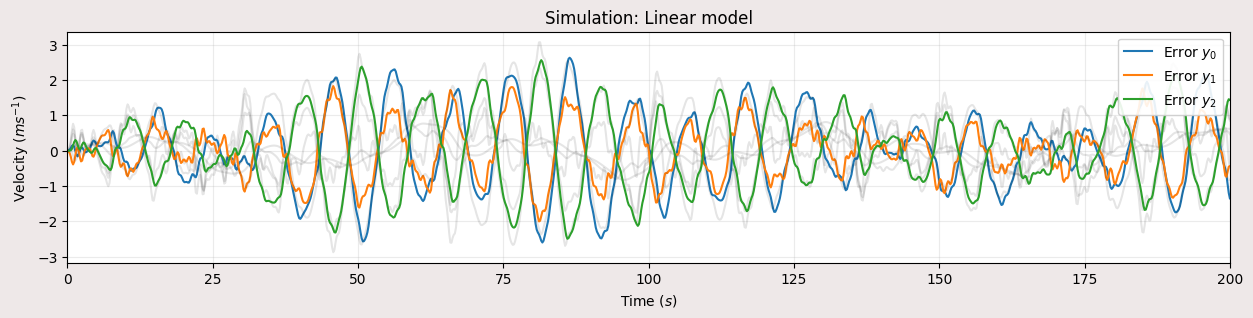

In [12]:
# Qualitative results of the linear model
lin_states, lin_outputs = simulate_model(sim_time=sim_time, model=linear_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], lin_outputs, plot_mode="error", title="Simulation: Linear model")

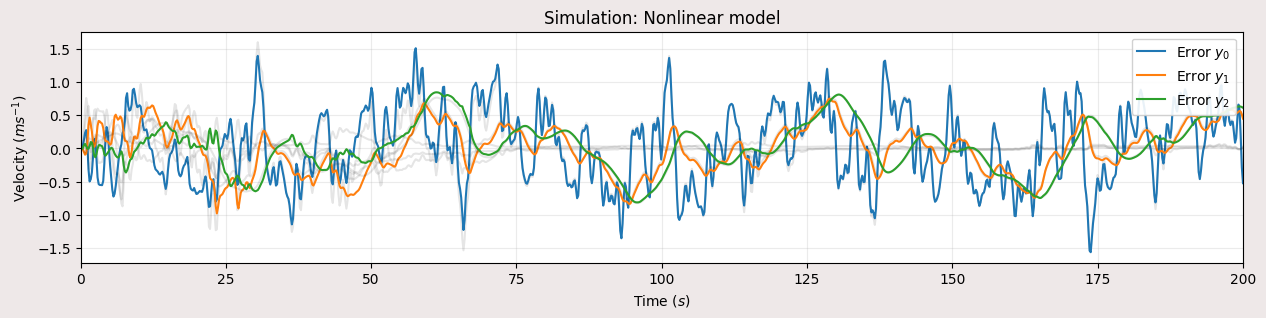

In [16]:
# Qualitative results of the linear model
nonlin_states, nonlin_outputs = simulate_model(sim_time=sim_time, model=nonlinear_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], nonlin_outputs, plot_mode="error", title="Simulation: Nonlinear model")

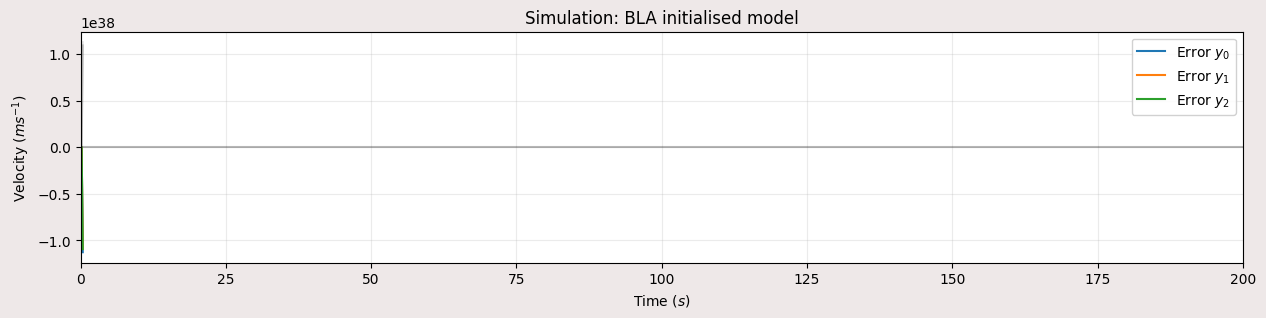

In [14]:
# Qualitative results of the linear model
comb_states, comb_outputs = simulate_model_withP(sim_time=sim_time, model=combined_model, x0=x0, u_ext=u)
plot_simulation(sim_time, datasets[z]["output"], comb_outputs, plot_mode="error", title="Simulation: BLA initialised model")

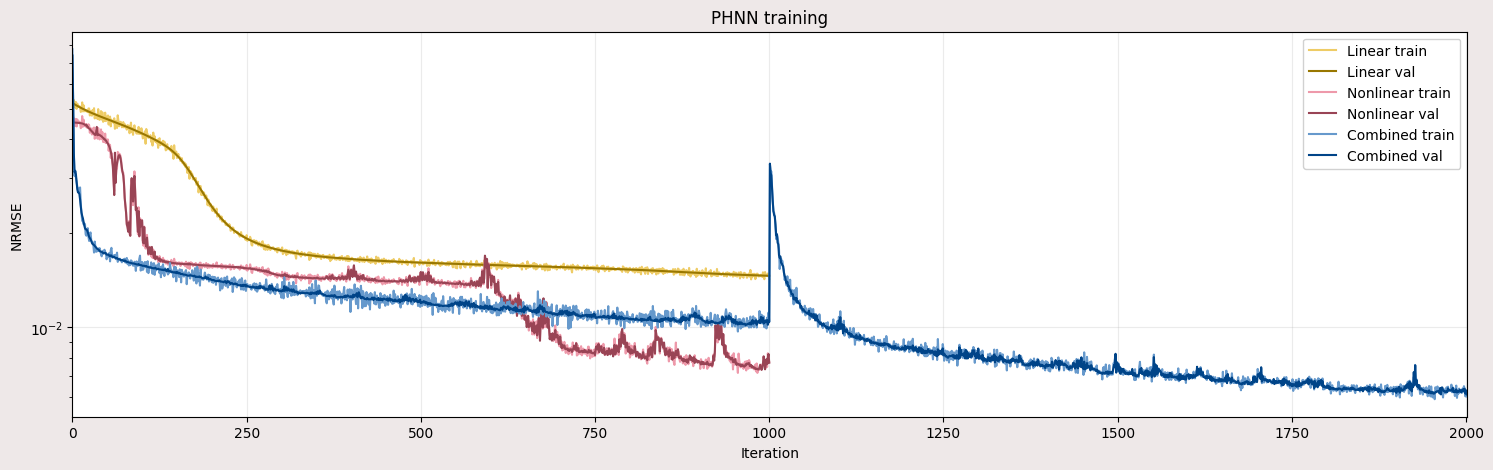

In [15]:
# Train times: 1hr for lin, 2.5hr for nonlin, ??? for comb
# Plot training progression:
fig = plt.figure(figsize=(18, 5))
plt.semilogy(lf_loss, label="Linear train", color="#EECC66")
plt.semilogy(lf_val_loss, label="Linear val", color="#997700")
plt.semilogy(nlf_loss, label="Nonlinear train", color="#EE99AA")
plt.semilogy(nlf_val_loss, label="Nonlinear val", color="#994455")
plt.semilogy(cf_loss, label="Combined train", color="#6699CC")
plt.semilogy(cf_val_loss, label="Combined val", color="#004488")

plt.ylabel('NRMSE')
plt.legend(loc=1)
plt.xlabel('Iteration')
plt.xlim([0, max(len(lf_loss), len(nlf_loss), len(cf_loss))])
plt.title("PHNN training")
plt.grid(alpha=0.25)
plt.show()